In [1]:
import snntorch as snn
from snntorch import surrogate
from snntorch import backprop
from snntorch import functional as SF
from snntorch import utils
from snntorch import spikeplot as splt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
import itertools
from torch.cuda.amp import autocast, GradScaler
from encoder_ import *

/tmp/ipykernel_345089/1275851596.py:3: DeprecationWarning: The module snntorch.backprop will be deprecated in  a future release. Writing out your own training loop will lead to substantially faster performance.
  from snntorch import backprop


In [2]:
# class RLencoder(torch.nn.Module):
#     def __init__(self, time_window, fire_window_ratio):
#         super(RLencoder, self).__init__()
#         self.time_window = time_window
#         self.fire_window = int(time_window * fire_window_ratio)

#     def forward(self, x):
#         batch_size, _, height, width = x.shape
#         spikes = torch.zeros(batch_size, height, width, self.time_window).to(x.device)
        
#         var = variance_map(x, 5)
#         latency = calculate_latency(var, self.time_window, self.fire_window, mode='log')
        
#         spike_prob = torch.rand(batch_size, height, width, self.time_window).to(x.device)

#         time_range = torch.arange(self.time_window).view(1, 1, 1, -1).to(x.device)
#         firing_mask = ((time_range >= latency.unsqueeze(-1)) & (time_range < (latency + self.fire_window).unsqueeze(-1))).squeeze().float()

#         spikes = (spike_prob < x.squeeze().unsqueeze(-1)) * firing_mask
#         # print(spikes.shape)

#         # print("spikes shape", spikes.shape)
#         # print("spike_prob shape", spike_prob.shape)
#         # print("x shape", x.shape)
#         # print("firing_mask shape", firing_mask.shape)
#         # print("time_range shape", time_range.shape)

#         return spikes

# def variance_map(image, kernel_size):
#     pad_size = kernel_size // 2
#     padded_image = F.pad(image, pad=(pad_size, pad_size, pad_size, pad_size), mode='reflect')
    
#     local_mean = F.avg_pool2d(padded_image, kernel_size, stride=1, padding=0)
#     squared_image = padded_image ** 2
#     local_mean_squared = F.avg_pool2d(squared_image, kernel_size, stride=1, padding=0)
    
#     variance = local_mean_squared - local_mean ** 2
#     return variance

# def calculate_latency(div_image, time_window, fire_window, mode='linear'):
#     min_div, max_div = div_image.min(), div_image.max()
#     normalized_div = (div_image - min_div) / (max_div - min_div)
#     if mode == "linear":
#         latency = (time_window - fire_window) * (1 - normalized_div)
#     elif mode == "log":
#         latency = 1 / (normalized_div + 1 / (time_window - fire_window))
    
#     return latency

In [3]:
# dataloader arguments
batch_size = 128
data_path='/tmp/data/MNIST'

dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

In [4]:
scaler = GradScaler()

/tmp/ipykernel_345089/4292142752.py:1: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/home/rmunuu/miniconda3/envs/ai/lib/python3.12/site-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


In [5]:
# Define a transform
transform = transforms.Compose([
            transforms.Resize((28, 28)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

mnist_train = datasets.MNIST(data_path, train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(data_path, train=False, download=True, transform=transform)

In [6]:
# Create DataLoaders
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=True)

In [7]:
# Network Architecture
num_inputs = 28*28
num_hidden = 1000
num_outputs = 10

# Temporal Dynamics
num_steps = 25

spike_grad = surrogate.fast_sigmoid(slope=25)
beta = 0.5

In [8]:
net = nn.Sequential(nn.Linear(num_inputs, num_hidden),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
                    nn.Linear(num_hidden, num_outputs),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, output=True)
                    ).to(device)

In [9]:
def batch_accuracy(train_loader, net, num_steps):
  with torch.no_grad():
    total = 0
    acc = 0
    net.eval()

    train_loader = iter(train_loader)
    for data, targets in train_loader:
      data = data.to(device)
      targets = targets.to(device)
      spk_rec, _ = forward_pass(net, num_steps, data)

      acc += SF.accuracy_rate(spk_rec, targets) * spk_rec.size(1)
      total += spk_rec.size(1)

  return acc/total

In [10]:
loss_fn = SF.ce_rate_loss()
optimizer = torch.optim.Adam(net.parameters(), lr=5e-4, betas=(0.9, 0.999))

In [11]:
time_window = 100
fire_window_ratio = 0.2

encoder = RLencoder(time_window, fire_window_ratio)


time_window:  100
fire_window:  20


In [12]:
def forward_pass(net, num_steps, data):
  mem_rec = []
  spk_rec = []
  utils.reset(net)  # resets hidden states for all LIF neurons in net

  spike_trains = encoder(data)
  spike_trains = spike_trains.permute(3, 0, 1, 2)

  for step in range(num_steps):
      spk_out, mem_out = net(spike_trains[step].view(batch_size, -1))
      spk_rec.append(spk_out)
      mem_rec.append(mem_out)

  return torch.stack(spk_rec), torch.stack(mem_rec)

In [13]:
# class RLencoder(torch.nn.Module):
#     def __init__(self, time_window, fire_window_ratio):
#         super(RLencoder, self).__init__()
#         self.time_window = time_window
#         self.fire_window = int(time_window * fire_window_ratio)
#         print("time_window: ", self.time_window)
#         print("fire_window: ", self.fire_window)

#     def forward(self, x):
#         batch_size, _, height, width = x.shape
#         spikes = torch.zeros(batch_size, height, width, self.time_window).to(x.device)

#         # gray = to_grayscale(x)
#         # max_latency = 100
#         var = variance_map(x, 5)
#         latency = calculate_latency(var, self.time_window, self.fire_window, mode='log')

#         spike_prob = torch.rand(batch_size, height, width).to(x.device)

#         for t in range(self.time_window):
#             firing_mask = ((t >= latency) & (t < latency + self.fire_window)).float().squeeze(1)
#             # print("spikes shape", spikes.shape)
#             # print("spike_prob shape", spike_prob.shape)
#             # print("x.squeeze shape", x.squeeze(1).shape)
#             # print("firing_mask shape", firing_mask.shape)
#             spikes[:, :, :, t] = (spike_prob < x.squeeze(1)) * firing_mask

#         return spikes

# # def to_grayscale(image):
# #     return torch.mean(image, dim=1, keepdim=True)

# def variance_map(image, kernel_size):
#     # kernel_size : odd
    
#     pad_size = kernel_size // 2
#     padded_image = F.pad(image, pad=(pad_size, pad_size, pad_size, pad_size), mode='reflect')
    
#     local_mean = F.avg_pool2d(padded_image, kernel_size, stride=1, padding=0)
    
#     squared_image = padded_image ** 2
#     local_mean_squared = F.avg_pool2d(squared_image, kernel_size, stride=1, padding=0)
    
#     variance = local_mean_squared - local_mean ** 2
#     # variance = torch.mean(variance, dim=1, keepdim=True)
    
#     return variance

# def calculate_latency(div_image, time_window, fire_window, mode='linear'):
#     min_div, max_div = div_image.min(), div_image.max()
#     normalized_div = (div_image - min_div) / (max_div - min_div)
#     if mode == "linear":
#         latency = (time_window - fire_window) * (1 - normalized_div)
#         return latency
#     elif mode == "log":
#         latency = 1/(normalized_div + 1/(time_window - fire_window))
#         return latency

# def plot_raster(spike_trains, num_neurons):
#     spike_trains = spike_trains.cpu().numpy()
#     plt.figure(figsize=(12, 8))
    
#     for neuron_idx in range(num_neurons):
#         neuron_spikes = spike_trains[0, neuron_idx // 28, neuron_idx % 28]
#         spike_times = neuron_spikes.nonzero()[0]
#         plt.vlines(spike_times, neuron_idx + 0.5, neuron_idx + 1.5)
    
#     plt.axis([0, 100, 0, 784])
#     plt.xlabel('Time')
#     plt.ylabel('Neuron Index')
#     plt.title('Raster Plot of Spikes')
#     plt.show()

In [14]:
num_epochs = 1
num_steps = time_window
loss_hist = []
test_acc_hist = []
counter = 0

for epoch in range(num_epochs):
    iter_counter = 0
    train_batch = iter(train_loader)

    for data, targets in train_batch:
        data = data.to(device)
        targets = targets.to(device)

        net.train()
        # spk_rec, _ = forward_pass(net, num_steps, data)
        # loss_val = loss_fn(spk_rec, targets)

        with autocast():
            spk_rec, _ = forward_pass(net, num_steps, data)
            loss_val = loss_fn(spk_rec, targets)

        # optimizer.zero_grad()
        # loss_val.backward()
        # optimizer.step()

        optimizer.zero_grad()
        scaler.scale(loss_val).backward()
        scaler.step(optimizer)
        scaler.update()

        loss_hist.append(loss_val.item())

        if counter % 50 == 0:
            with torch.no_grad():
                net.eval()

                test_acc = batch_accuracy(test_loader, net, num_steps)
                print(f"Iteration {counter}, Test Acc: {test_acc * 100:.2f}%\n")
                test_acc_hist.append(test_acc.item())

        counter += 1

/tmp/ipykernel_345089/1338605826.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/home/rmunuu/miniconda3/envs/ai/lib/python3.12/site-packages/torch/amp/autocast_mode.py:265: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Iteration 0, Test Acc: 9.80%



KeyboardInterrupt: 

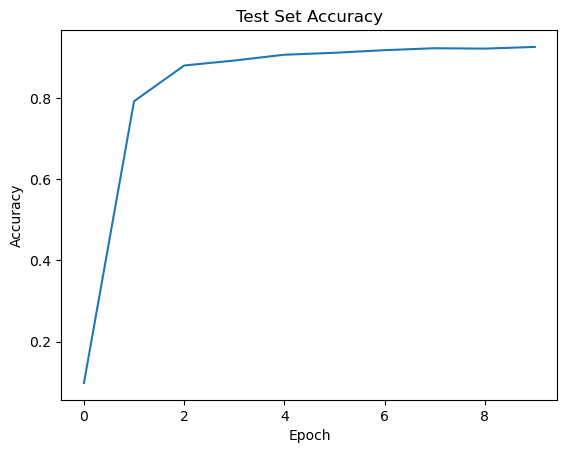

In [ ]:
fig = plt.figure(facecolor="w")
plt.plot(test_acc_hist)
plt.title("Test Set Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

In [ ]:
def forward_pass_test(net, num_steps, data):
  mem_rec = []
  spk_rec = []
  utils.reset(net)  # resets hidden states for all LIF neurons in net

  for step in range(num_steps):
      spk_out, mem_out = net(data.view(data.size(0), -1))
      spk_rec.append(spk_out)
      mem_rec.append(mem_out)

  return torch.stack(spk_rec), torch.stack(mem_rec)

In [ ]:
total = 0
correct = 0

# drop_last switched to False to keep all samples
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=False)

with torch.no_grad():
  net.eval()
  for data, targets in test_loader:
    data = data.to(device)
    targets = targets.to(device)

    # forward pass
    test_spk, _ = forward_pass_test(net, num_steps, data)

    # calculate total accuracy
    _, predicted = test_spk.sum(dim=0).max(1)
    total += targets.size(0)
    correct += (predicted == targets).sum().item()

In [ ]:
print(f"Total correctly classified test set images: {correct}/{total}")
print(f"Test Set Accuracy: {100 * correct / total:.2f}%")

Total correctly classified test set images: 9300/10000
Test Set Accuracy: 93.00%
